In [1]:
!pip install --upgrade libpysal

import pandas as pd
import geopandas as gpd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr
from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import statsmodels.api as sm 

# GWR
import geopandas as gpd
#from libpysal.weights import Distance
from libpysal.weights import Kernel

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error,r2_score
from sklearn.linear_model import LassoCV

# stepwise regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR



import warnings

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 2.3 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: libpysal
    Found existing installation: libpysal 4.9.2
    Uninstalling libpysal-4.9.2:
      Successfully uninstalled libpysal-4.9.2


In [60]:
trips = pd.read_csv("trips_regression.csv")

## GWR

In [62]:
trips = gpd.read_file('trips_regression.geojson')
trips.describe()

,USUALRES,SHAPE_area,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,railway_point,...,MetroCommute,BusCommute,CarorVanCommute,CycleCommute,avg_BUS_DIST,avg_METRO_DIST,avg_RAIL_DIST,avg_tripsALL,avg_trips0,avg_trips1
count,327.000000,3.270000e+02,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,...,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000
mean,13817.281239,1.872836e+05,0.063248,1.398461,0.329287,0.076078,0.015353,18.369942,24.724975,1.596677,...,0.194839,0.130200,0.136686,0.087155,168.104129,479.510877,396.362302,600.357514,139.950663,133.641648
std,6679.272637,2.110989e+05,0.146695,2.012836,1.021978,0.134833,0.277630,26.123272,26.480400,3.335446,...,0.092005,0.076908,0.065114,0.046671,160.354634,309.665808,236.991488,395.197884,138.088240,129.670094
min,610.053786,4.018281e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.675317,5.294271,4.082762,1.000000,0.000000,0.000000
25%,9155.831384,9.210312e+04,0.000000,0.504273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.155759,0.078041,0.109129,0.059286,61.081707,237.353369,216.392991,327.083333,43.000000,42.000000
50%,13567.716754,1.312771e+05,0.000000,0.880429,0.033603,0.021958,0.000000,9.054885,18.308117,0.000000,...,0.204918,0.132948,0.146939,0.089947,110.145640,418.786979,374.047096,560.000000,103.000000,97.750000
75%,17548.321482,1.876072e+05,0.055013,1.542509,0.157460,0.108405,0.000000,25.093680,37.243943,0.000000,...,0.248907,0.179835,0.180197,0.116551,222.747904,677.181360,525.178024,813.250000,194.000000,190.500000
max,35836.216283,1.922781e+06,1.376957,17.320731,8.743051,1.409971,5.020423,178.889632,171.489286,18.814849,...,0.456193,0.406015,0.301954,0.221951,841.039976,1404.020820,1195.401746,2562.500000,1006.000000,1006.000000


In [63]:
trips.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   LSOA11CD                327 non-null    object  
 1   USUALRES                327 non-null    float64 
 2   SHAPE_area              327 non-null    float64 
 3   commercial_area         327 non-null    float64 
 4   residential_area        327 non-null    float64 
 5   leisurepark_area        327 non-null    float64 
 6   retail_area             327 non-null    float64 
 7   school_point            327 non-null    float64 
 8   office_point            327 non-null    float64 
 9   bus_point               327 non-null    float64 
 10  railway_point           327 non-null    float64 
 11  subway_point            327 non-null    float64 
 12  tourism_point           327 non-null    float64 
 13  PnR_spaces              327 non-null    float64 
 14  endpoints0_count  

In [ ]:
# 计算endpoints0_count列数值的对数（以10为底），并创建一个新的列logcount0
trips['logcount0'] = np.log10(trips['endpoints0_count'])
trips['logcount1'] = np.log10(trips['endpoints1_count'])

In [ ]:
# 将负无穷值替换为0
trips['logcount0'].replace(-np.inf, 0, inplace=True)
trips['logcount1'].replace(-np.inf, 0, inplace=True)
trips.head()

In [ ]:
trips.rename(columns={'USUALRES': 'PopDensity'}, inplace=True)
trips.rename(columns={'road_length': 'RoadDensity'}, inplace=True)
trips.rename(columns={'residential_area': 'Residential'}, inplace=True)
trips.rename(columns={'commercial_area': 'Commercial'}, inplace=True)
trips.rename(columns={'leisurepark_area': 'LeisurePark'}, inplace=True)
trips.rename(columns={'retail_area': 'Retail'}, inplace=True)
trips.rename(columns={'school_point': 'School'}, inplace=True)
trips.rename(columns={'office_point': 'Office'}, inplace=True)
trips.rename(columns={'tourism_point': 'Tourism'}, inplace=True)
trips.rename(columns={'bus_point': 'Bus'}, inplace=True)
trips.rename(columns={'railway_point': 'Railway'}, inplace=True)
trips.rename(columns={'subway_point': 'Subway'}, inplace=True)

In [ ]:
# 因变量
g_y = trips[['logcount0']]
#g_y = trips[['endpoints1_count']]

# 自变量
g_X = trips[['PopDensity', 'RoadDensity','Commercial', 'Residential', 'LeisurePark', 'Retail', 'School', 'Office','Tourism', 'Bus', 'Railway','Subway']]

#y = trips[['endpoints0_count', 'endpoints1_count']]
#X = trips[['USUALRES', 'SHAPE_area', 'commercial_area', 'residential_area', 'leisurepark_area', 'retail_area', 'school_point', 'office_point', 'bus_point', 'railway_point', 'subway_point', 'tourism_point', 'endpointsALL', 'road_length']]


In [ ]:
trips.head(2)

In [ ]:
 import shapely.wkt

In [ ]:
print(trips['geometry'].dtype)


In [ ]:

# 定义一个函数用于解析polygon的坐标
def parse_polygon_coordinates(polygon_str):
    # 使用Shapely库解析WKT格式的polygon
    polygon = shapely.wkt.loads(polygon_str)
    
    # 提取polygon的顶点坐标
    coordinates = polygon.exterior.coords
    
    # 返回顶点坐标列表
    return coordinates

# 假设你有一个名为 'geometry' 的字段存储了WKT格式的polygon的坐标
trips['coordinates'] = trips['geometry'].apply(parse_polygon_coordinates)

# 将polygon的顶点坐标解析为经纬度
g_coords = []
for polygon_coords in trips['coordinates']:
    for lon, lat in polygon_coords:
        g_coords.append((lon, lat))

# g_coords 现在是一个包含经纬度元组的列表

# 坐标信息Latitude	Longitud
u = trips['Longitud']
v = trips['Latitude']
g_coords = list(zip(u,v))
 
# z标准化
# g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
# g_y = g_y.reshape((-1,1))
# g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

GWR模型拟合

In [ ]:
# 带宽选择函数
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(search_method='golden_section',criterion='AICc')
print('最佳带宽大小为：',gwr_bw)

In [ ]:
# GWR拟合
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw, fixed=False, kernel='bisquare', constant=True, spherical=True).fit()

In [ ]:
gwr_results.summary()

In [ ]:
# 回归参数
var_names=['cof_Intercept','cof_TotPop90','cof_PctRural','cof_PctEld','cof_PctFB','cof_PctPov','cof_PctBlack']
gwr_coefficent=pd.DataFrame(gwr_results.params,columns=var_names)
 
# 回归参数显著性
gwr_flter_t=pd.DataFrame(gwr_results.filter_tvals())
 
# 将点数据回归结果放到面上展示 
# 主要是由于两个文件中的记录数不同，矢量面中的记录比csv中多几条，因此需要将没有参加gwr的区域去掉
georgia_data_geo=gp.GeoDataFrame(georgia_data,geometry=gp.points_from_xy(georgia_data.X, georgia_data.Y))
georgia_data_geo=georgia_data_geo.join(gwr_coefficent)
 
# 将回归参数与面数据结合
georgia_shp_geo=gp.sjoin(georgia_shp,georgia_data_geo, how="inner", op='intersects').reset_index()

In [ ]:
# 将gdf的列名作为自变量名称列表传入y参数，将目标列名作为因变量名称传入X参数
# 假设gdf是您的GeoDataFrame

# 将geometry列设置为GeoDataFrame的索引
trips = trips.set_geometry('geometry')


# 假设trips2是您的DataFrame

# 计算endpoints0_count列数值的对数（以10为底），并创建一个新的列logcount0
trips2['logcount0'] = np.log10(trips2['endpoints0_count'])

# 选择您想要分析的因变量和自变量
y = trips2[['endpoints0_count', 'endpoints1_count']]
X = trips2[['USUALRES', 'SHAPE_area', 'commercial_area', 'residential_area', 'leisurepark_area', 'retail_area', 'school_point', 'office_point', 'bus_point', 'railway_point', 'subway_point', 'tourism_point', 'endpointsALL', 'road_length']]

# 创建一个gwr对象
gwr_model = gwr.GWR(y, X, trips.geometry, quiet=True)

# 打印系数、标准误差、t统计量、p值等
gwr_model.summary()


In [ ]:
fig,ax = plt.subplots(nrows=2, ncols=4,figsize=(20,10))
axes = ax.flatten()
 
for i in range(0,len(axes)-1):
    
    ax=axes[i]
    ax.set_title(var_names[i])
    georgia_shp_geo.plot(ax=ax,column=var_names[i],edgecolor='white',cmap='Blues',legend=True)
    
    if (gwr_flter_t[i] == 0).any():
        georgia_shp_geo[gwr_flter_t[i] == 0].plot(color='lightgrey', ax=ax, edgecolor='white') # 灰色部分表示该系数不显著
 
    
    ax.set_axis_off()
    if i+1==7:
        axes[7].axis('off')
        
plt.show()

In [ ]:
# 可视化回归系数
gwr_model.plot()
plt.show()


In [ ]:
import pandas as pd
from spatialpy.gwr import Moran_Local_Rate

# 假设gdf是您的GeoDataFrame，并且它包含一个名为'geometry'的列

# 计算莫兰指数
moran_values = Moran_Local_Rate(gdf['geometry'])

# 将莫兰指数添加到gdf中
gdf['MORAN'] = moran_values

# 查看结果
print(gdf.head())


In [ ]:

# Assuming all datasets have a common identifier 'lsoa11cd', 
# perform spatial joins or attribute joins as necessary
# Example for a spatial join:
# lsoa_data = lsoa_data.merge(endpoints_data, on='lsoa11cd', how='left')

# Prepare your data for GWR - ensure all data are in the same Coordinate Reference System (CRS)
# ...

# Select bandwidth for GWR
gwr_selector = Sel_BW(coordinates, y, X)
gwr_bandwidth = gwr_selector.search()

# Run GWR model
gwr_model = GWR(coordinates, y, X, gwr_bandwidth)
gwr_results = gwr_model.fit()

# View results
print(gwr_results.summary())


## Correlation Analysis

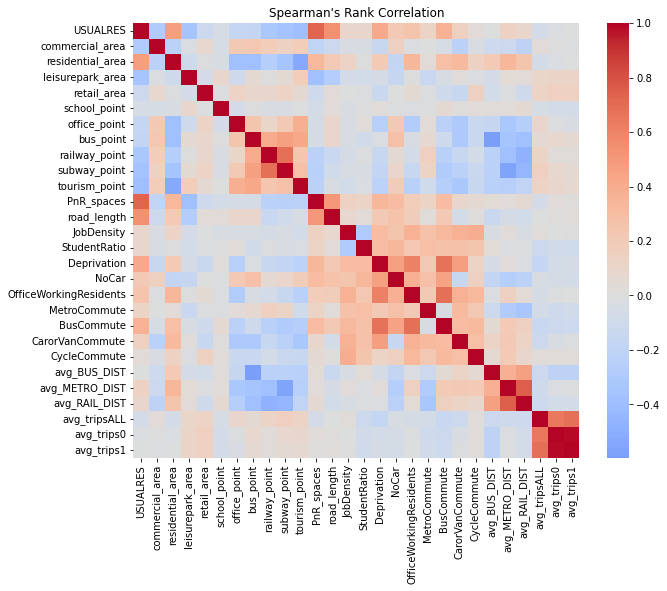

In [19]:
# Check Spearman's rank correlation
correlation_matrix = trips.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", center=0, mask=correlation_matrix.isnull())
plt.title("Spearman's Rank Correlation")
plt.savefig('Spearman Rank Correlation_original.jpg')
plt.show()

In [20]:
spearman_corr.to_excel("spearman_corr_matrix1.xlsx")

In [4]:
# Check multicollinearity
vif = pd.DataFrame()
vif["Features"] = trips.columns
vif["VIF Factor"] = [variance_inflation_factor(trips.values, i) for i in range(trips.shape[1])]
print(vif)

                  Features  VIF Factor
0                 USUALRES   17.005608
1          commercial_area    1.344975
2         residential_area    2.195267
3         leisurepark_area    1.475175
4              retail_area    1.485683
5             school_point    1.141097
6             office_point    2.388243
7                bus_point    3.879888
8            railway_point    2.242702
9             subway_point    2.479717
10           tourism_point    2.596963
11              PnR_spaces    8.444429
12             road_length   19.333071
13              JobDensity  133.239064
14            StudentRatio    5.853215
15             Deprivation    6.574111
16                   NoCar   86.151152
17  OfficeWorkingResidents   53.044349
18            MetroCommute   22.442801
19              BusCommute   17.557255
20         CarorVanCommute   28.588285
21            CycleCommute   11.948675
22            avg_BUS_DIST    4.176949
23          avg_METRO_DIST    8.760978
24           avg_RAIL_DIS

VIF (Variance Inflation Factor) is an indicator used to assess the presence of multicollinearity between independent variables. Usually, a VIF value greater than 10 or more than 5 is considered to be multicollinearity.
<br><br>
Based on the results given, we can see that the following independent variables have high VIF values:
<br><br>
- JobDensity: VIF Factor = 127.56<br>
- NoCar: VIF Factor = 85.00<br>
- OfficeWorkingResidents: VIF Factor = 52.44<br>
- MetroCommute: VIF Factor = 21.55<br>
- CarorVanCommute: VIF Factor = 28.22<br>
- Deprivation: VIF Factor = 6.20<br>
- StudentRatio: VIF Factor = 5.84<br>
- BusCommute: VIF Factor = 17.15<br>
- CycleCommute: VIF Factor = 11.86<br>
- avg_RAIL_DIST: VIF Factor = 9.72<br>
- avg_METRO_DIST: VIF Factor = 8.53<br>
- avg_BUS_DIST: VIF Factor = 4.00<br><br>
As a rule, VIF values greater than 10 or more than 5 are considered to be multicollinear. Therefore, I will consider deleting some of these independent variables with high VIF values to reduce the effect of multicollinearity. Next I will try to choose to delete some of these independent variables to improve the performance of the model or try other methods to deal with multicollinearity such as using regularisation.

In [5]:
# 计算自变量之间的Spearman相关系数矩阵
correlation_matrix = trips.corr(method='spearman')

# 打印与其他自变量相关性较高的几组自变量
highly_correlated_variables = []
for col in correlation_matrix.columns:
    highly_correlated_with_col = correlation_matrix[col][(correlation_matrix[col] > 0.5) & (correlation_matrix[col] < 1)]
    if not highly_correlated_with_col.empty:
        for index, correlation in highly_correlated_with_col.items():
            highly_correlated_variables.append((col, index, correlation))

# 打印结果
print("Groups of independent variables with high correlation with other independent variables:")
for variable1, variable2, correlation in highly_correlated_variables:
    print(f"{variable1} and {variable2}: Correlation = {correlation:.2f}")


Groups of independent variables with high correlation with other independent variables:
USUALRES and PnR_spaces: Correlation = 0.73
USUALRES and road_length: Correlation = 0.54
railway_point and subway_point: Correlation = 0.68
subway_point and railway_point: Correlation = 0.68
PnR_spaces and USUALRES: Correlation = 0.73
PnR_spaces and road_length: Correlation = 0.51
road_length and USUALRES: Correlation = 0.54
road_length and PnR_spaces: Correlation = 0.51
Deprivation and OfficeWorkingResidents: Correlation = 0.61
Deprivation and BusCommute: Correlation = 0.67
OfficeWorkingResidents and Deprivation: Correlation = 0.61
OfficeWorkingResidents and BusCommute: Correlation = 0.69
BusCommute and Deprivation: Correlation = 0.67
BusCommute and OfficeWorkingResidents: Correlation = 0.69
avg_METRO_DIST and avg_RAIL_DIST: Correlation = 0.75
avg_RAIL_DIST and avg_METRO_DIST: Correlation = 0.75
avg_tripsALL and avg_trips0: Correlation = 0.65
avg_tripsALL and avg_trips1: Correlation = 0.68
avg_trip

In [42]:
## First I will remove all the variables whose VIF >10
variables_to_drop = ['JobDensity', 'NoCar', 'OfficeWorkingResidents', 'MetroCommute', 
                     'CarorVanCommute','avg_RAIL_DIST']

trips = trips.drop(columns=variables_to_drop)


# 检查 multicollinearity
vif = pd.DataFrame()
vif["Features"] = trips.columns
vif["VIF Factor"] = [variance_inflation_factor(trips.values, i) for i in range(trips.shape[1])]
print(vif)


            Features  VIF Factor
0    commercial_area    1.296895
1   residential_area    2.002282
2   leisurepark_area    1.413416
3        retail_area    1.432476
4       school_point    1.131791
5       office_point    1.987341
6          bus_point    3.753789
7      railway_point    2.055967
8       subway_point    2.405931
9      tourism_point    2.329113
10        PnR_spaces    5.593208
11       road_length   13.371084
12      StudentRatio    3.144122
13       Deprivation    4.528841
14        BusCommute    8.617475
15      CycleCommute    6.283204
16      avg_BUS_DIST    3.464504
17    avg_METRO_DIST    5.466217
18      avg_tripsALL    6.736160
19        avg_trips0   37.082766
20        avg_trips1   41.409573


In [8]:
# 计算自变量之间的Spearman相关系数矩阵
correlation_matrix = trips.corr(method='spearman')

# 打印与其他自变量相关性较高的几组自变量
highly_correlated_variables = []
for col in correlation_matrix.columns:
    highly_correlated_with_col = correlation_matrix[col][(correlation_matrix[col] > 0.5) & (correlation_matrix[col] < 1)]
    if not highly_correlated_with_col.empty:
        for index, correlation in highly_correlated_with_col.items():
            highly_correlated_variables.append((col, index, correlation))

# 打印结果
print("Groups of independent variables with high correlation with other independent variables:")
for variable1, variable2, correlation in highly_correlated_variables:
    print(f"{variable1} and {variable2}: Correlation = {correlation:.2f}")


Groups of independent variables with high correlation with other independent variables:
USUALRES and PnR_spaces: Correlation = 0.73
USUALRES and road_length: Correlation = 0.54
PnR_spaces and USUALRES: Correlation = 0.73
PnR_spaces and road_length: Correlation = 0.51
road_length and USUALRES: Correlation = 0.54
road_length and PnR_spaces: Correlation = 0.51
Deprivation and OfficeWorkingResidents: Correlation = 0.61
OfficeWorkingResidents and Deprivation: Correlation = 0.61
avg_METRO_DIST and avg_RAIL_DIST: Correlation = 0.75
avg_RAIL_DIST and avg_METRO_DIST: Correlation = 0.75
avg_tripsALL and avg_trips0: Correlation = 0.65
avg_tripsALL and avg_trips1: Correlation = 0.68
avg_trips0 and avg_tripsALL: Correlation = 0.65
avg_trips0 and avg_trips1: Correlation = 0.99
avg_trips1 and avg_tripsALL: Correlation = 0.68
avg_trips1 and avg_trips0: Correlation = 0.99


In [9]:
## 根据自变量之间的相关性去除与因变量coefficient较小的一个
variables_to_drop = ['BusCommute','railway_point']

trips = trips.drop(columns=variables_to_drop)

# 检查 multicollinearity
vif = pd.DataFrame()
vif["Features"] = trips.columns
vif["VIF Factor"] = [variance_inflation_factor(trips.values, i) for i in range(trips.shape[1])]
print(vif)

KeyError: "['BusCommute', 'railway_point'] not found in axis"

In [45]:
## 去掉对选址模型没有作用的VIF>5的变量
variables_to_drop = ['road_length','CycleCommute']

trips = trips.drop(columns=variables_to_drop)

# 检查 multicollinearity
vif = pd.DataFrame()
vif["Features"] = trips.columns
vif["VIF Factor"] = [variance_inflation_factor(trips.values, i) for i in range(trips.shape[1])]
print(vif)

            Features  VIF Factor
0    commercial_area    1.263044
1   residential_area    1.913513
2   leisurepark_area    1.378672
3        retail_area    1.390925
4       school_point    1.123551
5       office_point    1.892788
6          bus_point    3.318318
7       subway_point    2.042399
8      tourism_point    2.270987
9         PnR_spaces    4.446730
10      StudentRatio    2.779646
11       Deprivation    2.982585
12      avg_BUS_DIST    3.366285
13    avg_METRO_DIST    4.634346
14      avg_tripsALL    6.198185
15        avg_trips0   36.981208
16        avg_trips1   41.364690


In [10]:
trips.head(2)

,USUALRES,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,subway_point,tourism_point,...,OfficeWorkingResidents,MetroCommute,CarorVanCommute,CycleCommute,avg_BUS_DIST,avg_METRO_DIST,avg_RAIL_DIST,avg_tripsALL,avg_trips0,avg_trips1
0,6348.609213,0.823290,0.000000,0.015644,0.057913,0.0,39.789334,26.526222,4.421037,61.894519,...,0.148336,0.146341,0.092683,0.121951,68.699428,202.332489,222.974000,175.5,80.0,40.0
1,5164.131283,0.553093,0.086604,0.012435,0.026352,0.0,36.699410,78.641593,15.728319,89.127139,...,0.267760,0.234694,0.108844,0.068027,95.222448,121.435602,103.816109,732.0,65.0,65.0


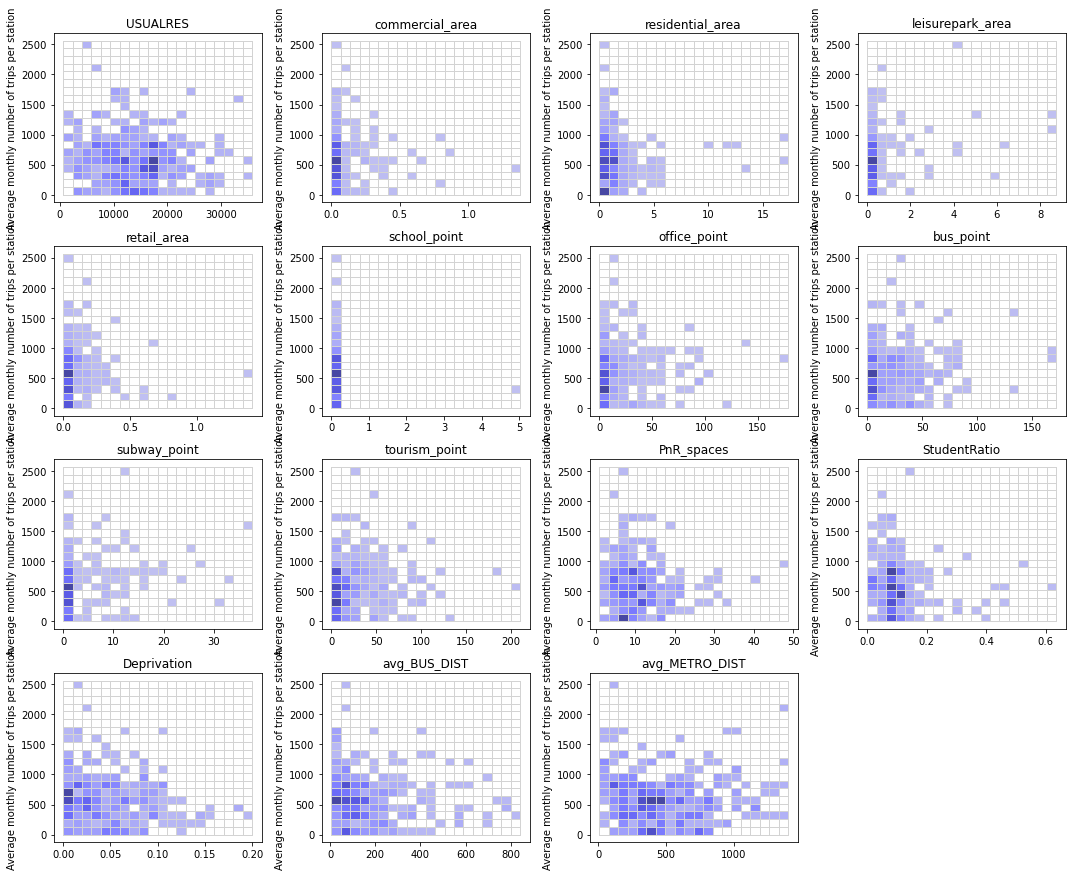

In [13]:
# 特征列表
features = ['USUALRES','commercial_area', 'residential_area', 'leisurepark_area', 'retail_area', 'school_point', 
            'office_point', 'bus_point', 'subway_point', 'tourism_point', 'PnR_spaces', 'StudentRatio', 
            'Deprivation', 'avg_BUS_DIST', 'avg_METRO_DIST']

# 创建子图
plt.figure(figsize=(15, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(4, 4, i)
    sns.histplot(data=trips, x=feature, y='avg_tripsALL', bins=20, color='blue', edgecolor='lightgrey', kde=True)
    plt.xlabel("")
    plt.ylabel("Average monthly number of trips per station")
    plt.title(feature)

# 调整子图布局
plt.tight_layout()
plt.show()

In [14]:
trips.describe()

,USUALRES,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,subway_point,tourism_point,...,OfficeWorkingResidents,MetroCommute,CarorVanCommute,CycleCommute,avg_BUS_DIST,avg_METRO_DIST,avg_RAIL_DIST,avg_tripsALL,avg_trips0,avg_trips1
count,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,...,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000
mean,13817.281239,0.063248,1.398461,0.329287,0.076078,0.015353,18.369942,24.724975,2.683793,23.726828,...,0.207309,0.194839,0.136686,0.087155,168.104129,479.510877,396.362302,600.357514,139.950663,133.641648
std,6679.272637,0.146695,2.012836,1.021978,0.134833,0.277630,26.123272,26.480400,5.787310,30.038208,...,0.085270,0.092005,0.065114,0.046671,160.354634,309.665808,236.991488,395.197884,138.088240,129.670094
min,610.053786,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.675317,5.294271,4.082762,1.000000,0.000000,0.000000
25%,9155.831384,0.000000,0.504273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.182838,0.155759,0.109129,0.059286,61.081707,237.353369,216.392991,327.083333,43.000000,42.000000
50%,13567.716754,0.000000,0.880429,0.033603,0.021958,0.000000,9.054885,18.308117,0.000000,15.134519,...,0.228774,0.204918,0.146939,0.089947,110.145640,418.786979,374.047096,560.000000,103.000000,97.750000
75%,17548.321482,0.055013,1.542509,0.157460,0.108405,0.000000,25.093680,37.243943,2.046462,34.597665,...,0.261843,0.248907,0.180197,0.116551,222.747904,677.181360,525.178024,813.250000,194.000000,190.500000
max,35836.216283,1.376957,17.320731,8.743051,1.409971,5.020423,178.889632,171.489286,37.629697,210.437964,...,0.393357,0.456193,0.301954,0.221951,841.039976,1404.020820,1195.401746,2562.500000,1006.000000,1006.000000


Due to unavalability of 2021 London census data of some LSOA areas, the correspoding row of bike trip ending station has null value as well. However, distance relevant variables are still complete for following analysing. So Stations with null value would be imputed rather than removed from this analysis.

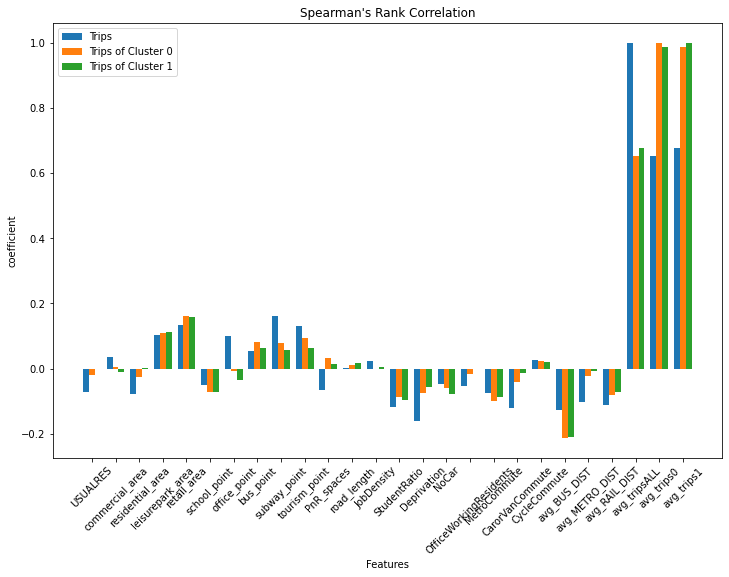

In [15]:


# Compute the Spearman correlation matrix using the trips dataframe
spearman_corr = trips.corr(method='spearman')

# Drop avg_tripsALL, avg_trips0, and avg_trips1 from the correlation matrix
spearman_corr1 = spearman_corr.drop(['avg_tripsALL', 'avg_trips0', 'avg_trips1'])

# Plot as grouped bar plots
plt.figure(figsize=(12, 8))

# Define width for each group
bar_width = 0.25

# Define x positions for each group
x = np.arange(len(spearman_corr1.columns))

# Plot bars for avg_tripsALL
plt.bar(x - bar_width, spearman_corr.loc['avg_tripsALL'], width=bar_width, label='Trips')

# Plot bars for avg_trips0
plt.bar(x, spearman_corr.loc['avg_trips0'], width=bar_width, label='Trips of Cluster 0')

# Plot bars for avg_trips1
plt.bar(x + bar_width, spearman_corr.loc['avg_trips1'], width=bar_width, label='Trips of Cluster 1')

# Add labels and title
plt.xlabel('Features')
plt.ylabel("coefficient")
plt.title("Spearman's Rank Correlation")
plt.xticks(ticks=x, labels=spearman_corr.columns, rotation=45)
plt.legend()

# Save and display the plot
plt.savefig('Spearman Rank Correlation_grouped_bars.jpg')
plt.show()



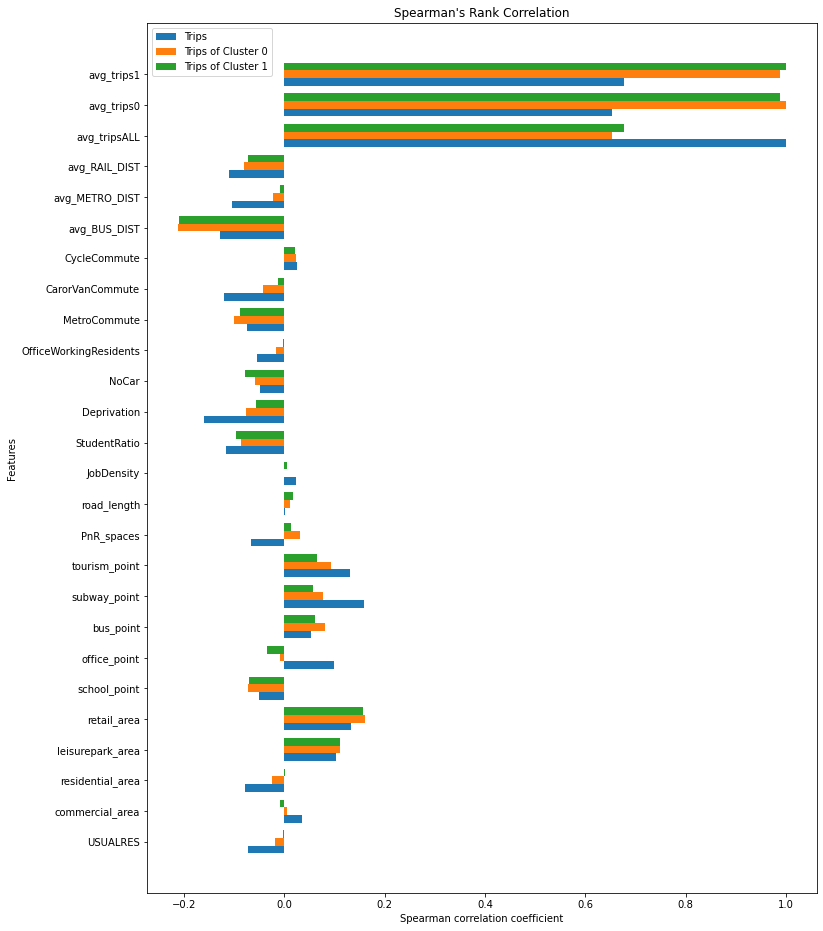

NameError: name 'excel_file' is not defined

In [16]:
# Compute the Spearman correlation matrix using the trips dataframe
spearman_corr = trips.corr(method='spearman')

# Drop avg_tripsALL, avg_trips0, and avg_trips1 from the correlation matrix
spearman_corr1 = spearman_corr.drop(['avg_tripsALL', 'avg_trips0', 'avg_trips1'])

# Plot as grouped bar plots
plt.figure(figsize=(12, 16))

# Define height for each group
bar_height = 0.25

# Define y positions for each group
y = np.arange(len(spearman_corr1.columns))

# Plot bars for avg_tripsALL
plt.barh(y - bar_height, spearman_corr.loc['avg_tripsALL'], height=bar_height, label='Trips')

# Plot bars for avg_trips0
plt.barh(y, spearman_corr.loc['avg_trips0'], height=bar_height, label='Trips of Cluster 0')

# Plot bars for avg_trips1
plt.barh(y + bar_height, spearman_corr.loc['avg_trips1'], height=bar_height, label='Trips of Cluster 1')

# Add labels and title
plt.ylabel('Features')
plt.xlabel("Spearman correlation coefficient")
plt.title("Spearman's Rank Correlation")
plt.yticks(ticks=y, labels=spearman_corr.columns)
plt.legend()

# Save and display the plot
#plt.savefig('Spearman Rank Correlation_grouped_bars_horizontal.jpg')
plt.show()

# 定义文件名
#excel_file = "spearman_corr_matrix.xlsx"

# 保存相关性矩阵到Excel文件
spearman_corr.to_excel(excel_file)

#print(f"Spearman correlation matrix saved to {excel_file}")

In [ ]:
'''
# 创建 SimpleImputer 对象
imputer = SimpleImputer(strategy='most_frequent') 

#拟合模型并进行插补
data_imputed = imputer.fit_transform(trips)

#将结果转回 DataFrame格式
trips = pd.DataFrame(data_imputed, columns=trips.columns, index=trips.index)
trips.describe()
'''

In [ ]:
trips.head(2)

In [ ]:
'''
# 选择需要标准化的列
#columns_to_standardize = ['RetailRatio','CommerRatio', 'ResidentRatio', 'ParkRatio', 'METRO_DIST', 'CAZ_DIST', 'ResCoverS', 'BUS_DIST', 'RetailCoverS', 'ParkCoverS', 'CommerCoverS']
#columns_to_standardize = ['leisurepark_area_ratio',	retail_area_ratio	endpoints0_count_ratio	endpoints1_count_ratio	office_point_ratio	school_point_ratio	subway_point_ratio	tourism_point_ratio	endpointsALL_ratio	bus_point_ratio
columns_to_standardize = ['Pop Density','Road Density',
                          'Leisure Park', 'Retail', 'Commercial','Residential',
                          'EndTrips0', 'EndTrips1', 'EndTripsALL', 
                          'Office', 'School', 'Tourism',
                          'Subway Station', 'Bus Station','Railway Station']

 # 创建StandardScaler对象并进行标准化
scaler = MinMaxScaler()
trips[columns_to_standardize] = scaler.fit_transform(trips[columns_to_standardize])


# 输出前几行数据以确认修改已生效
trips.head()
'''

**Result Explanation:**<br><br>
From the Spearman regression plot, we can observe that the coefficient between Road Density and residential area is very high (0.88). Additionally, "Road Density" shows a relatively high correlation with "Bus Station" (0.66), "Tourism" (0.54), "Pop Density" (0.53), and "Commercial" (0.47). Therefore, **Road Density** will be removed from the model to reduce multicollinearity.
<br><br>
Furthermore, Population Density was calculated as the ratio of "usual residents within LSOA unit" to "area of LSOA unit (km²)". This variable's role overlaps with "residential area", which is calculated as the ratio of "residential landuse area within LSOA unit" to "area of LSOA unit (km²)". Considering that the data source for population density is "English IMD 2019", which is not as recent as the "residential landuse" data (fetched using the Quick OSM plugin in QGIS in 2023), **"Pop Density"** will be removed from the model as well.

## Lasso Regression

In [11]:
from sklearn.linear_model import LassoCV, lasso_path, Lasso

import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### Lasso Regression Model for all destinations

In [2]:
trips = pd.read_csv("trips_regression.csv")
trips.head()

,USUALRES,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,railway_point,subway_point,...,MetroCommute,BusCommute,CarorVanCommute,CycleCommute,avg_BUS_DIST,avg_METRO_DIST,avg_RAIL_DIST,avg_tripsALL,avg_trips0,avg_trips1
0,6348.609213,0.823290,0.000000,0.015644,0.057913,0.0,39.789334,26.526222,4.421037,4.421037,...,0.146341,0.073171,0.092683,0.121951,68.699428,202.332489,222.974000,175.5,80.0,40.0
1,5164.131283,0.553093,0.086604,0.012435,0.026352,0.0,36.699410,78.641593,10.485546,15.728319,...,0.234694,0.153061,0.108844,0.068027,95.222448,121.435602,103.816109,732.0,65.0,65.0
2,8658.258191,0.152089,1.730381,0.046057,0.142752,0.0,178.889632,10.222265,0.000000,0.000000,...,0.125984,0.060367,0.044619,0.062992,72.674825,259.885956,274.890141,865.0,352.0,352.0
3,17578.891822,0.032715,2.498695,0.031789,0.365598,0.0,81.144696,22.130372,7.376791,7.376791,...,0.225092,0.073801,0.084871,0.081181,140.881618,140.361295,146.815742,311.5,45.0,22.5
4,12764.149681,0.000000,0.000000,0.077747,0.000000,0.0,8.042942,88.472367,8.042942,8.042942,...,0.000000,0.000000,0.000000,0.000000,102.339264,254.246432,298.988391,375.5,277.0,138.5


In [4]:
# Select columns with 16 independent variables & dependent logcount

# Split into predictor variables (X) and outcome variable (y)remove 'PnR_spaces'
#X = trips[['road_length','commercial_area', 'residential_area', 'leisurepark_area', 'retail_area', 'school_point', 'office_point', 'bus_point', 'subway_point', 'tourism_point', 'StudentRatio', 'Deprivation', 'avg_BUS_DIST', 'avg_METRO_DIST']]

# 选择特征
X = trips.drop(['avg_tripsALL', 'avg_trips0', 'avg_trips1'], axis=1)

# 定义目标变量
y = trips['avg_tripsALL']

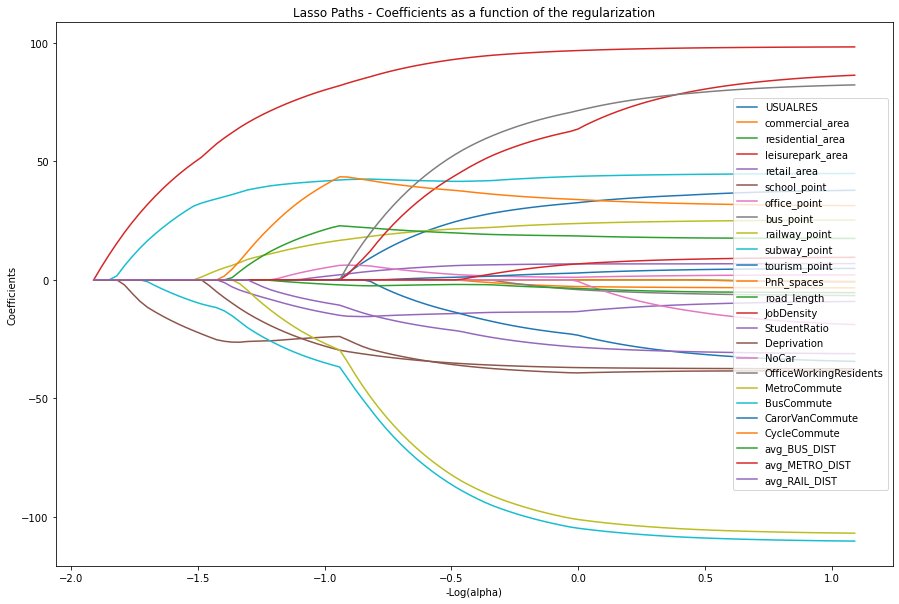

In [8]:
# 计算Lasso路径
alphas, coefs, _ = lasso_path(X_scaled, y, alphas=None)

# 绘制Lasso路径
plt.figure(figsize=(15, 10))
neg_log_alphas = -np.log10(alphas)
for coef_l, feature in zip(coefs, X.columns):
    plt.plot(neg_log_alphas, coef_l, label=feature)

plt.xlabel('-Log(alpha)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Coefficients as a function of the regularization')
plt.legend()
plt.axis('tight')
plt.show()

Best alpha value: 10.0


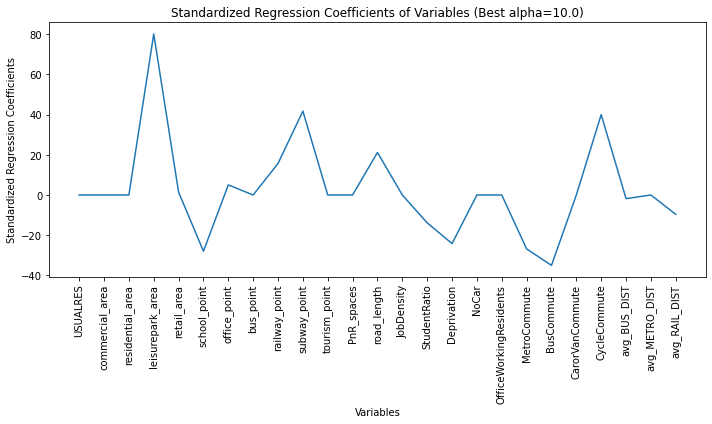

In [6]:
# First, standardize X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a LassoCV object with a specified range of alpha values
alphas = [0.01, 0.1, 1, 10]
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=0)

# Fit the model using the fit method
lasso_cv.fit(X_scaled, y)

# Print the best alpha value
best_alpha = lasso_cv.alpha_
print(f"Best alpha value: {best_alpha}")

# Train a Lasso model using the best alpha value
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_scaled, y)

# Plot the standardized regression coefficients
plt.figure(figsize=(10, 6))
plt.plot(range(len(X.columns)), lasso.coef_)
plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.xlabel('Variables')
plt.ylabel('Standardized Regression Coefficients')
plt.title(f'Standardized Regression Coefficients of Variables (Best alpha={best_alpha})')
plt.tight_layout()
plt.show()

In [9]:
# 特征标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 创建LassoCV实例：这里使用10折交叉验证
lasso_cv = LassoCV(alphas=None, cv=10, max_iter=10000, normalize=False)

# 拟合模型
lasso_cv.fit(X_scaled, y)

# 获取最佳alpha值
best_alpha = lasso_cv.alpha_
print("最佳alpha值:", best_alpha)

最佳alpha值: 30.631290064120936


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [12]:
# Build final Lasso Regression Model
# 分割数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 已知的最佳alpha值
best_alpha = 30.63 # 示例，实际使用时请替换为通过交叉验证得到的值

# 创建Lasso模型实例
lasso = Lasso(alpha=best_alpha)

# 拟合模型
lasso.fit(X_train_scaled, y_train)

# 预测
y_pred = lasso.predict(X_test_scaled)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("模型的均方误差(MSE):", mse)
print("模型的R^2得分:", r2)

# 查看系数
coefficients = pd.DataFrame(data=lasso.coef_, index=X.columns, columns=['Coefficients'])
print(coefficients)


模型的均方误差(MSE): 140484.5477757009
模型的R^2得分: 0.040364130526588604
                        Coefficients
USUALRES                   -0.000000
commercial_area             0.000000
residential_area            0.000000
leisurepark_area           55.729441
retail_area                 0.000000
school_point               -2.199665
office_point                0.000000
bus_point                   0.000000
railway_point               0.000000
subway_point               17.774027
tourism_point               0.000000
PnR_spaces                 -0.000000
road_length                 0.000000
JobDensity                 -0.000000
StudentRatio               -0.000000
Deprivation                -3.184319
NoCar                      -0.000000
OfficeWorkingResidents     -0.000000
MetroCommute               -0.000000
BusCommute                -38.931789
CarorVanCommute            -0.000000
CycleCommute                0.000000
avg_BUS_DIST               -0.000000
avg_METRO_DIST             -0.000000
avg_RAIL_DIS

### Lasso Regression Model for cluster 0

In [86]:

# Lasso Regression
# Select columns with 16 independent variables & dependent logcount


# Split into predictor variables (X) and outcome variable (y)remove 'PnR_spaces'
X = trips[['commercial_area', 'residential_area', 'leisurepark_area', 'retail_area', 'school_point', 'office_point', 'bus_point', 'subway_point', 'tourism_point', 'StudentRatio', 'Deprivation', 'avg_BUS_DIST', 'avg_METRO_DIST']]
y = trips['avg_trips0']

# Perform Lasso regression with cross-validation to find the best alpha (lambda) value
lasso = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=123)
lasso.fit(X, y)

# Display the best alpha (lambda) value
best_alpha = lasso.alpha_
print("Best Alpha (Lambda):", best_alpha)

# Train the final Lasso model with the best alpha (lambda) value
lasso_final = LassoCV(alphas=[best_alpha], cv=5, random_state=123)
lasso_final.fit(X, y)

# Display regression coefficients and sort by absolute coefficient value
lasso_coef = pd.DataFrame({'Variable': X.columns, 'Coefficient': lasso_final.coef_})
lasso_coef['Absolute_Coefficient'] = abs(lasso_coef['Coefficient'])
sorted_lasso_coef = lasso_coef.sort_values(by='Absolute_Coefficient', ascending=False)
print(sorted_lasso_coef[['Variable', 'Coefficient']])  

Best Alpha (Lambda): 890.2150854450392
            Variable  Coefficient
12      avg_BUS_DIST    -0.122629
13    avg_METRO_DIST     0.011201
0         PnR_spaces    -0.000000
1    commercial_area    -0.000000
2   residential_area    -0.000000
3   leisurepark_area     0.000000
4        retail_area     0.000000
5       school_point    -0.000000
6       office_point    -0.000000
7          bus_point    -0.000000
8       subway_point     0.000000
9      tourism_point     0.000000
10      StudentRatio    -0.000000
11       Deprivation    -0.000000


In [ ]:
# 计算模型性能指标
y_pred = lasso.predict(X)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
print("均方误差 (MSE):", mse)
print("均方根误差 (RMSE):", rmse)
print("决定系数 (R^2):", r2)

#  交叉验证
cv_scores = cross_val_score(lasso, X, y, cv=5)  # 5 折交叉验证
print("交叉验证得分:", cv_scores)
print("平均交叉验证得分:", np.mean(cv_scores))

In [ ]:
 #Export model_stats to an Excel file named "step_model.xlsx"
lasso_coef.to_excel("lasso_coef0.xlsx", index=True)

### Lasso Regression Model for cluster 1

In [85]:

# Lasso Regression
# Select columns with 16 independent variables & dependent logcount

# Split into predictor variables (X) and outcome variable (y)remove 'PnR_spaces'
X = trips[['commercial_area', 'residential_area', 'leisurepark_area', 'retail_area', 'school_point', 'office_point', 'bus_point', 'subway_point', 'tourism_point', 'StudentRatio', 'Deprivation', 'avg_BUS_DIST', 'avg_METRO_DIST']]
y = trips['avg_trips1']
#y = trips['EndTripsALL','EndTrips0', 'EndTrips1']


# Perform Lasso regression with cross-validation to find the best alpha (lambda) value
lasso = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=123)
lasso.fit(X, y)

# Display the best alpha (lambda) value
best_alpha = lasso.alpha_
print("Best Alpha (Lambda):", best_alpha)

# Train the final Lasso model with the best alpha (lambda) value
lasso_final = LassoCV(alphas=[best_alpha], cv=5, random_state=123)
lasso_final.fit(X, y)

# Display regression coefficients and sort by absolute coefficient value
lasso_coef = pd.DataFrame({'Variable': X.columns, 'Coefficient': lasso_final.coef_})
lasso_coef['Absolute_Coefficient'] = abs(lasso_coef['Coefficient'])
sorted_lasso_coef = lasso_coef.sort_values(by='Absolute_Coefficient', ascending=False)
print(sorted_lasso_coef[['Variable', 'Coefficient']])  

Best Alpha (Lambda): 5.857020818056673
            Variable  Coefficient
2   leisurepark_area    11.951910
7       subway_point     3.919995
6          bus_point    -0.694749
11      avg_BUS_DIST    -0.203172
8      tourism_point     0.101783
12    avg_METRO_DIST     0.062404
5       office_point    -0.029003
0    commercial_area    -0.000000
1   residential_area     0.000000
3        retail_area     0.000000
4       school_point    -0.000000
9       StudentRatio    -0.000000
10       Deprivation    -0.000000


In [ ]:
# 计算模型性能指标
y_pred = lasso.predict(X)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
print("均方误差 (MSE):", mse)
print("均方根误差 (RMSE):", rmse)
print("决定系数 (R^2):", r2)

#  交叉验证
cv_scores = cross_val_score(lasso, X, y, cv=5)  # 5 折交叉验证
print("交叉验证得分(cv_scores):", cv_scores)
print("平均交叉验证得分(means_cv_scores):", np.mean(cv_scores))

In [ ]:
 #Export model_stats to an Excel file named "step_model.xlsx"
lasso_coef.to_excel("lasso_coef1.xlsx", index=True)

以上步骤用lasso regression初步筛选出相关系数为0的变量。Distance to Central Activity Zone(CAZ), Student Rate, Cycle to Commute population ratio, population density这些变量被剔除后，其他自变量被加入斯皮尔曼回归分析。<br><br>
The above steps were used in lasso regression to initially screen out variables with a correlation coefficient of zero." Distance to Central Activity Zone(CAZ)", "Cycle to Commute population ratio","Ratio of student residents" and "population density" were eliminated and the remaining independent variables were added to the Spearman regression analysis.

In [ ]:
# Select the columns of interest
columns_of_interest = ['EndTripsALL','EndTrips0', 'EndTrips1',  
                          'Leisure Park', 'Retail', 'Commercial','Residential',
                          'Office',  'Tourism','Bus Station']

# variable removed :'Road Density','POP density': high correlation with other independent variables
# variable removed : 'School','Subway Station','Railway Station': close to zero coefficient in lasso regression model

# Calculate Spearman's rank correlation for the selected columns
correlation_matrix = trips[columns_of_interest].corr(method='spearman')

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Spearman's Rank Correlation")
plt.show()

In [ ]:
# Check multicollinearity
X = trips[['Leisure Park', 'Retail', 'Commercial','Residential',
                          'Office',  'Tourism','Bus Station']]
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

In [ ]:
trips.head(2)

### CLuster 0 OLS model

In [ ]:
# Final OLS
# Define the independent variables and the dependent variable

# Split into predictor variables (X) and outcome variable (y)remove 'PnR_spaces'
X = trips[['leisurepark_area', 'subway_point', 'office_point', 'bus_point', 'tourism_point', 'avg_BUS_DIST', 'avg_METRO_DIST']]
y = trips['avg_trips0']

# Add an intercept term
X = sm.add_constant(X)

In [ ]:

# Create and fit the linear regression model for EndTrips0
lm_endtrips0 = sm.OLS(y0, X).fit()

# Get AIC and BIC for EndTrips0 model
aic_value_endtrips0 = lm_endtrips0.aic
bic_value_endtrips0 = lm_endtrips0.bic

# Print AIC and BIC for EndTrips0 model
print("EndTrips0 Model:")
print(f'AIC 0: {aic_value_endtrips0}')
print(f'BIC 0: {bic_value_endtrips0}')
print(lm_endtrips0.summary())


### CLuster 1 OLS model

In [ ]:

# Create and fit the linear regression model for EndTrips1
lm_endtrips1 = sm.OLS(y1, X).fit()

# Get AIC and BIC for EndTrips1 model
aic_value_endtrips1 = lm_endtrips1.aic
bic_value_endtrips1 = lm_endtrips1.bic

# Print AIC and BIC for EndTrips1 model
print("EndTrips1 Model:")
print(f'AIC: {aic_value_endtrips1}')
print(f'BIC: {bic_value_endtrips1}')
print(lm_endtrips1.summary())


### CLuster 2 OLS model

In [ ]:
# Create and fit the linear regression model for EndTripsALL
lm_endtripsall = sm.OLS(y2, X).fit()

# Get AIC and BIC for EndTripsALL model
aic_value_endtripsall = lm_endtripsall.aic
bic_value_endtripsall = lm_endtripsall.bic

# Print AIC and BIC for EndTripsALL model
print("EndTripsALL Model:")
print(f'AIC all: {aic_value_endtripsall}')
print(f'BIC all: {bic_value_endtripsall}')
print(lm_endtripsall.summary())


In [ ]:
# Final Lasso
# Train the final Lasso model with the best alpha (lambda) value
lasso_final = LassoCV(alphas=[best_alpha], cv=5, random_state=123)
lasso_final.fit(X, y)

# Display regression coefficients and sort by absolute coefficient value
lasso_coef = pd.DataFrame({'Variable': X.columns, 'Coefficient': lasso_final.coef_})
lasso_coef['Absolute_Coefficient'] = abs(lasso_coef['Coefficient'])
sorted_lasso_coef = lasso_coef.sort_values(by='Absolute_Coefficient', ascending=False)
print(sorted_lasso_coef[['Variable', 'Coefficient']])

# Predict logcount on the entire dataset
y_pred = lasso_final.predict(X)

# Evaluate the model on training data
mse_train = mean_squared_error(y, y_pred)
r2_train = r2_score(y, y_pred)
cv_r2 = cross_val_score(lasso_final, X, y, cv=5, scoring='r2').mean()

# Print additional evaluation metrics
print(f'Mean Squared Error (MSE) on training data: {mse_train}')
print(f'R-squared on training data: {r2_train}')
print(f'Cross-validated R-squared: {cv_r2}')

In [ ]:


# Split data into training and testing sets
X_train, X_test, y0_train, y0_test = train_test_split(X, y0, test_size=0.2, random_state=42)
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42)
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=42)

# Perform Lasso regression with cross-validation to find the best alpha (lambda) value
lasso0 = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=123)
lasso0.fit(X_train, y0_train)

lasso1 = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=123)
lasso1.fit(X_train, y1_train)

lasso2 = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=123)
lasso2.fit(X_train, y2_train)

# Get the best alpha value
best_alpha0 = lasso0.alpha_
best_alpha1 = lasso1.alpha_
best_alpha2 = lasso2.alpha_

# Get the coefficients
coefficients0 = lasso0.coef_
coefficients1 = lasso1.coef_
coefficients2 = lasso2.coef_

# Print the best alpha values
print("Best alpha for EndTrips0:", best_alpha0)
print("Best alpha for EndTrips1:", best_alpha1)
print("Best alpha for EndTripsALL:", best_alpha2)

# Print the coefficients
print("Coefficients for EndTrips0:", coefficients0)
print("Coefficients for EndTrips1:", coefficients1)
print("Coefficients for EndTripsALL:", coefficients2)

# Predictions
y0_pred = lasso0.predict(X_test)
y1_pred = lasso1.predict(X_test)
y2_pred = lasso2.predict(X_test)

# Model evaluation
mse0 = mean_squared_error(y0_test, y0_pred)
mse1 = mean_squared_error(y1_test, y1_pred)
mse2 = mean_squared_error(y2_test, y2_pred)

r2_0 = r2_score(y0_test, y0_pred)
r2_1 = r2_score(y1_test, y1_pred)
r2_2 = r2_score(y2_test, y2_pred)

print("MSE for EndTrips0:", mse0)
print("MSE for EndTrips1:", mse1)
print("MSE for EndTripsALL:", mse2)

print("R^2 for EndTrips0:", r2_0)
print("R^2 for EndTrips1:", r2_1)
print("R^2 for EndTripsALL:", r2_2)


The lasso regression results show that the distance to the nearest bus station (m), nearest metro station (m), the population density and university percentage variables are not significant at the 95% level of confidence. However, ratio of household with no car is significant, while the distance to the nearest metro station ranked second in the p-value performance.

Examining the variables in more detail shows that there is some positive correlation between bike parking counts at docking points and area of leisure park within 500m buffer area, as well as commercial and retail landuse. Besideds, there is some negative correlation between bike parking counts at docking points and road density around the station, also distance to central activity zone centre and deprivation rate of the corresonding LSOA area. However, the strength of the association appears relatively low.

## TRY1:SVM

Mean Squared Error (MSE): 146846.63612890337
R-squared: -0.003094657540550827


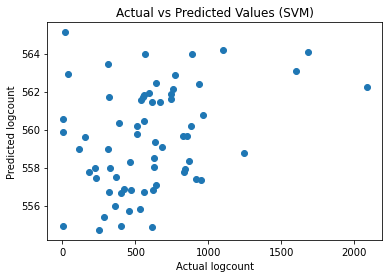

In [117]:


# Define the independent variables and the dependent variable
# Split into predictor variables (X) and outcome variable (y)remove 'PnR_spaces'
X = trips[['road_length','commercial_area', 'residential_area', 'leisurepark_area', 'retail_area', 'school_point', 'office_point', 'bus_point', 'subway_point', 'tourism_point', 'StudentRatio', 'Deprivation', 'avg_BUS_DIST', 'avg_METRO_DIST','PnR_spaces',]]
y = trips['avg_tripsALL']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and fit the Support Vector Regression (SVR) model
svm_model = SVR(kernel='rbf')  # You can choose other kernels like 'linear','rbf' or 'poly' based on your data
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Print evaluation metrics with explanations
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r_squared}')

# Plot actual vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual logcount')
plt.ylabel('Predicted logcount')
plt.title('Actual vs Predicted Values (SVM)')
plt.show()


In [118]:
# Get feature weights from the SVM model
feature_weights = svm_model.coef_

# Plot feature weights
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_weights)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Feature Weights from SVM Model')
plt.show()


AttributeError: coef_ is only available when using a linear kernel

## Stepwise Regression

For comparison, the second model-stepwise regression was built. Both forward and backward selection were checked by using AIC criterion, and backward selection was found a better model accuracy and fit. 

In [34]:
X = trips.drop(columns=['avg_tripsALL', 'avg_trips0', 'avg_trips1'])
y = trips['avg_tripsALL']

In [35]:
linreg = LinearRegression()
linreg.fit(X, y)

# 执行逐步回归
# RFE（Recursive Feature Elimination）来选择特征。这是另一种特征选择方法，它通过递归地考虑越来越少的特征来选择特征，并在每次迭代中训练模型
#指定了n_features_to_select=2，这意味着希望选择两个最重要的特征

selector = RFE(linreg, n_features_to_select=8)
selector.fit(X, y)
print(selector.support_)
print(X.columns[selector.support_])

[False False False False False False False False False False False False
 False  True  True  True False  True  True  True  True  True False False
 False]
Index(['JobDensity', 'StudentRatio', 'Deprivation', 'OfficeWorkingResidents',
       'MetroCommute', 'BusCommute', 'CarorVanCommute', 'CycleCommute'],
      dtype='object')


In [45]:
trips = trips.drop(columns=['avg_trips0','avg_trips0'])

In [46]:
trips.head()

,USUALRES,commercial_area,residential_area,leisurepark_area,retail_area,school_point,office_point,bus_point,railway_point,subway_point,...,OfficeWorkingResidents,MetroCommute,BusCommute,CarorVanCommute,CycleCommute,avg_BUS_DIST,avg_METRO_DIST,avg_RAIL_DIST,avg_tripsALL,avg_trips1
0,6348.609213,0.823290,0.000000,0.015644,0.057913,0.0,39.789334,26.526222,4.421037,4.421037,...,0.148336,0.146341,0.073171,0.092683,0.121951,68.699428,202.332489,222.974000,175.5,40.0
1,5164.131283,0.553093,0.086604,0.012435,0.026352,0.0,36.699410,78.641593,10.485546,15.728319,...,0.267760,0.234694,0.153061,0.108844,0.068027,95.222448,121.435602,103.816109,732.0,65.0
2,8658.258191,0.152089,1.730381,0.046057,0.142752,0.0,178.889632,10.222265,0.000000,0.000000,...,0.267744,0.125984,0.060367,0.044619,0.062992,72.674825,259.885956,274.890141,865.0,352.0
3,17578.891822,0.032715,2.498695,0.031789,0.365598,0.0,81.144696,22.130372,7.376791,7.376791,...,0.182984,0.225092,0.073801,0.084871,0.081181,140.881618,140.361295,146.815742,311.5,22.5
4,12764.149681,0.000000,0.000000,0.077747,0.000000,0.0,8.042942,88.472367,8.042942,8.042942,...,0.000000,0.000000,0.000000,0.000000,0.000000,102.339264,254.246432,298.988391,375.5,138.5


In [55]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 加载数据集
X = trips.drop(columns=['avg_tripsALL'])
y = trips['avg_tripsALL']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 创建逻辑回归模型
lr = LogisticRegression()

# 创建后退法对象
rfe = RFE(lr, n_features_to_select=2)

# 运行后退法
rfe = rfe.fit(X_train, y_train)

# 选择最佳特征组合
X_train_new = X_train[:, rfe.support_]
X_test_new = X_test[:, rfe.support_]

# 训练模型
lr.fit(X_train_new, y_train)

# 预测测试集
y_pred = lr.predict(X_test_new)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

ValueError: Unknown label type: 'continuous'

In [51]:
import numpy as np
import pandas as pd

#加载线性回归需要的模块和库
import statsmodels.api as sm #最小二乘
from statsmodels.formula.api import ols #加载ols模型

#分训练集测试集
import random
random.seed(123) #设立随机数种子
a=random.sample(range(len(trips)),round(len(trips)*0.3))
trips_test=[]
for i in a:
    trips_test.append(trips.iloc[i])
trips_test=pd.DataFrame(trips_test)
trips_train=trips.drop(a)


In [52]:
#定义向前逐步回归函数
def forward_select(data,target):
    variate=set(data.columns)  #将字段名转换成字典类型
    variate.remove(target)  #去掉因变量的字段名
    selected=[]
    current_score,best_new_score=float('inf'),float('inf')  #目前的分数和最好分数初始值都为无穷大（因为AIC越小越好）
    #循环筛选变量
    while variate:
        aic_with_variate=[]
        for candidate in variate:  #逐个遍历自变量
            formula="{}~{}".format(target,"+".join(selected+[candidate]))  #将自变量名连接起来
            aic=ols(formula=formula,data=data).fit().aic  #利用ols训练模型得出aic值
            aic_with_variate.append((aic,candidate))  #将第每一次的aic值放进空列表
        aic_with_variate.sort(reverse=True)  #降序排序aic值
        best_new_score,best_candidate=aic_with_variate.pop()  #最好的aic值等于删除列表的最后一个值，以及最好的自变量等于列表最后一个自变量
        if current_score>best_new_score:  #如果目前的aic值大于最好的aic值
            variate.remove(best_candidate)  #移除加进来的变量名，即第二次循环时，不考虑此自变量了
            selected.append(best_candidate)  #将此自变量作为加进模型中的自变量
            current_score=best_new_score  #最新的分数等于最好的分数
            print("aic is {},continuing!".format(current_score))  #输出最小的aic值
        else:
            print("for selection over!")
            break
    formula="{}~{}".format(target,"+".join(selected))  #最终的模型式子
    print("final formula is {}".format(formula))
    model=ols(formula=formula,data=data).fit()
    return(model)


In [54]:
forward_select(data=trips_train,target="value")

KeyError: 'value'

In [50]:
from statsmodels.formula.api import ols
import pandas as pd
import random

# 假设 trips 是已经定义好的 DataFrame

# 分割数据集
random.seed(123)
a = random.sample(range(len(trips)), round(len(trips) * 0.3))
target_var = trips_train['avg_tripsALL']
trips_train = trips_train.drop(columns=['avg_tripsALL'])
trips_test = trips_test.drop(columns=['avg_tripsALL'])

# 利用向前逐步回归筛选变量
forward_select(train_data=trips_train,
               target=target_var,
               test_data=trips_test)

# 定义向前逐步回归函数
def forward_select(train_data, target, test_data=None):
    variate = set(train_data.columns)  # 将字段名转换成字典类型
    variate.remove(target)  # 去掉因变量的字段名
    selected = []
    current_score, best_new_score = float('inf'), float('inf')  # 目前的分数和最好分数初始值都为无穷大（因为AIC越小越好）
    # 循环筛选变量
    while variate:
        aic_with_variate = []
        for candidate in variate:  # 逐个遍历自变量
            formula = "{} ~ {}".format(target, " + ".join(selected + [candidate]))  # 将自变量名连接起来
            aic = ols(formula=formula, data=train_data).fit().aic  # 利用ols训练模型得出aic值
            aic_with_variate.append((aic, candidate))  # 将第每一次的aic值放进空列表
        aic_with_variate.sort(reverse=True)  # 降序排序aic值
        best_new_score, best_candidate = aic_with_variate.pop()  # 最好的aic值等于删除列表的最后一个值，以及最好的自变量等于列表最后一个自变量
        if current_score > best_new_score:  # 如果目前的aic值大于最好的aic值
            variate.remove(best_candidate)  # 移除加进来的变量名，即第二次循环时，不考虑此自变量了
            selected.append(best_candidate)  # 将此自变量作为加进模型中的自变量
            current_score = best_new_score  # 最新的分数等于最好的分数
            print("aic is {}, continuing!".format(current_score))  # 输出最小的aic值
        else:
            print("forward selection over!")
            break
    formula = "{} ~ {}".format(target, " + ".join(selected))  # 最终的模型式子
    print("final formula is {}".format(formula))
    model = ols(formula=formula, data=train_data).fit()
    if test_data is not None:
        test_model = ols(formula=formula, data=test_data).fit()
        return model, test_model, selected
    else:
        return model, selected

# 利用向前逐步回归筛选变量
#forward_select(data=trips_train.drop(columns=['avg_tripsALL']),target='avg_tripsALL')

# 利用向前逐步回归筛选变量
forward_select(train_data=trips_train,
               target=target_var,
               test_data=trips_test)

TypeError: unhashable type: 'Series'

In [29]:

# Stepwise Regression
# Full model
#X = trips[['commercial_area', 'residential_area', 'leisurepark_area', 'retail_area', 'school_point', 'office_point', 'bus_point', 'subway_point', 'tourism_point', 'StudentRatio', 'Deprivation', 'avg_BUS_DIST', 'avg_METRO_DIST','PnR_spaces',]]
X = trips.drop(columns=['avg_tripsALL', 'avg_trips0', 'avg_trips1'])
X = sm.add_constant(X)
y = trips['avg_tripsALL']
full_model = sm.OLS(y, X).fit()


# Backward stepwise selection using AIC criterion
step_model = full_model
while True:
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    max_vif = vif[vif['Variable'] != 'const']['VIF'].max()
    
    if max_vif > 10:  # You can adjust the VIF threshold as needed
        remove_variable = vif[vif['VIF'] == max_vif]['Variable'].values[0]
        X = X.drop(columns=[remove_variable])
        step_model = sm.OLS(y, X).fit()
    else:
        break

# Display the stepwise regression summary
print(step_model.summary())

# Check for multicollinearity (VIF)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF:")
print(vif)


                            OLS Regression Results                            
Dep. Variable:           avg_tripsALL   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     2.308
Date:                Fri, 16 Feb 2024   Prob (F-statistic):           0.000641
Time:                        15:23:55   Log-Likelihood:                -2391.2
No. Observations:                 327   AIC:                             4832.
Df Residuals:                     302   BIC:                             4927.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    547

In [ ]:
# Export model_stats to an Excel file named "step_model.xlsx"
#model_stats.to_excel("step_model1.xlsx", index=False)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- PnR_spaces

  warnings.warn(message, FutureWarning)


ValueError: X has 15 features, but LassoCV is expecting 14 features as input.

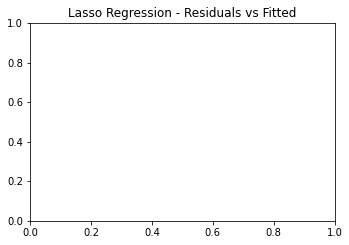

In [119]:
# Lasso regression
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.title("Lasso Regression - Residuals vs Fitted")
plt.scatter(lasso.predict(X), lasso.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

# Stepwise regression
plt.subplot(2, 2, 2)
plt.title("Stepwise Regression - Residuals vs Fitted")
plt.scatter(step_model.predict(X), step_model.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()


We can see from the Residual vs Fitted plot that residuals are randomly scattered and centered around zero, it suggests that the variance of the residuals is roughly constant across all levels of the predicted values. The Stepwise Regression model is doing a more reasonable job of capturing the variation in the data than Lasso Regression.

Overall, we can conclude from this regression analysis that in London Santander Service Area. Increased distances to bus station and residential area within buffer area are associated with lower bike-sharing demand. Additionally, bike-sharing ridership is significantly higher among populations that have fewer employment deprived residents, and in areas with a higher proportion of cycling lanes. 

In [ ]:
# Perform stepwise regression removing outliers
outlier_indices = [10, 12, 13]
trips_removed_outliers = trips.drop(outlier_indices)
step_model_removed_outliers = ols('logcount ~ ST_DIST + DOWNTOWN_DIST + CYL_PER1 + employment + uni + population_density', data=trips_removed_outliers).fit().step(direction='both', verbose=0)
print(step_model_removed_outliers.summary())

Compare AIC values：比较Lasso回归模型和逐步回归模型的AIC值，AIC值越小越好，表示模型对数据的拟合越好。 comparing the AIC values of the Lasso regression model and the stepwise regression model, the smaller the AIC value, the better it indicates that the model fits the data better.

In [ ]:
'''
if lasso_aic < step_aic:
    print("Lasso Regression is preferred with AIC =", lasso_aic)
else:
    print("Stepwise Regression is preferred with AIC =", step_aic)
'''

In [ ]:


# Assuming you have a DataFrame 'trips1' with 'BUS_DIST' and 'logcount' columns
x = trips1['BUS_DIST']
y = trips1['logcount']

# Calculate the maximum frequency location
max_freq_location = x[y.idxmax()]

# Calculate the 75th percentile location
percentile_95_location = np.percentile(x, 95)
percentile_75_location = np.percentile(x, 75)
percentile_50_location = np.percentile(x, 50)
percentile_25_location = np.percentile(x, 25)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, s=10)
plt.axvline(x=max_freq_location, color='r', linestyle='--', label='Max Frequency Location')
plt.axvline(x=percentile_95_location, color='y', linestyle='--', label='95% Percentile Location')
plt.axvline(x=percentile_75_location, color='g', linestyle='--', label='75% Percentile Location')
plt.axvline(x=percentile_50_location, color='pink', linestyle='--', label='50% Percentile Location')
plt.axvline(x=percentile_25_location, color='orange', linestyle='--', label='25% Percentile Location')

plt.xlabel('BUS_DIST')
plt.ylabel('Frequency of Bike Trips (logcount)')
plt.title('Distance Decay Plot')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:

# 定义距离衰减函数
def distance_decay(distance, decay_rate):
    return np.exp(-decay_rate * distance)

# 从trips1数据集中获取BUS_DIST和logcount列
bus_dist = trips1['BUS_DIST']
logcount = trips1['logcount']

# 计算距离衰减曲线
decay_rate = 0.01  # 适当调整衰减率
decay_values = distance_decay(bus_dist, decay_rate)


# 绘制距离衰减曲线
plt.figure(figsize=(10, 6))
plt.scatter(bus_dist, decay_values, c=logcount, cmap='viridis', alpha=0.5)
plt.axvline(x=bus_dist[turning_points[0]], color='red', linestyle='--', label='Turning Point')
plt.xlabel('Distance to nearest bus station(m)')
plt.ylabel('Decay Values')
plt.title('Distance Decay Curve')
plt.colorbar(label='logcount of trips frequency')
plt.grid(True)

# 导出距离衰减曲线图，设置 dpi 参数以提高分辨率
plt.savefig('distance_decay_curve_BusStation.jpg', dpi=200)

# 显示图形
plt.show()


## TRY2 :Ramdom Forest Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [120]:
# Select columns with 16 independent variables & dependent logcount
trips = pd.read_csv("trips_regression.csv")

# Split into predictor variables (X) and outcome variable (y)remove 'PnR_spaces'
X = trips[['road_length','commercial_area', 'residential_area', 'leisurepark_area', 'retail_area', 'school_point', 'office_point', 'bus_point', 'subway_point', 'tourism_point', 'StudentRatio', 'Deprivation', 'avg_BUS_DIST', 'avg_METRO_DIST']]
y = trips['avg_tripsALL']


In [121]:
# create feature matrix X and target variable y


#X = sm.add_constant(X)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# 创建决策树回归模型
regressor = DecisionTreeRegressor(random_state=42)

# 拟合模型
regressor.fit(X_train, y_train)

# 进行预测
y_pred = regressor.predict(X_test)


# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

# Print evaluation metrics with explanations
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 324435.38257575757


In [122]:
# 假设 X 是自变量，y 是连续型目标变量 
regressor = DecisionTreeRegressor(random_state=42)

# 拟合模型
regressor.fit(X, y)

# 获取特征重要性分数
feature_importance = regressor.feature_importances_

# 将特征重要性分数与对应的特征名字关联起来
feature_names = X.columns  # 假设你的自变量在一个DataFrame中
feature_importance_dict = dict(zip(feature_names, feature_importance))

# 将特征重要性评分表按分数从大到小排序
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# 打印排序后的特征重要性评分表
for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: avg_METRO_DIST, Importance: 0.1950402247259584
Feature: leisurepark_area, Importance: 0.11718385115396349
Feature: avg_BUS_DIST, Importance: 0.11205728039212678
Feature: road_length, Importance: 0.09936975105957893
Feature: residential_area, Importance: 0.0943572586294778
Feature: StudentRatio, Importance: 0.07309706962303775
Feature: bus_point, Importance: 0.06185767964797008
Feature: retail_area, Importance: 0.057703949252315576
Feature: office_point, Importance: 0.0449668903646263
Feature: commercial_area, Importance: 0.044112266866146915
Feature: subway_point, Importance: 0.03643612657290715
Feature: Deprivation, Importance: 0.03376460991381028
Feature: tourism_point, Importance: 0.03005304179808063
Feature: school_point, Importance: 0.0


AttributeError: 'BarContainer' object has no attribute 'get_array'

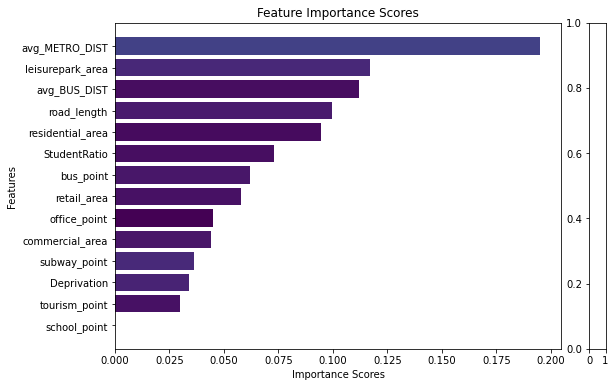

In [123]:
# 假设 X 是自变量，y 是连续型目标变量 logcount
regressor = DecisionTreeRegressor(random_state=42)

# 拟合模型
regressor.fit(X, y)

# 获取特征重要性分数
feature_importance = regressor.feature_importances_

# Associate feature importance scores with corresponding feature names
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort feature importance scores in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=False)

# Plot the horizontal bar chart with different colors
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(feature_importance)  # Use a colormap for colors

# Extract feature names and importance scores for plotting
features, importance_scores = zip(*sorted_feature_importance)

# Create a horizontal bar chart
bars = plt.barh(features, importance_scores, color=colors)

# Customize the plot
plt.title('Feature Importance Scores')
plt.xlabel('Importance Scores')
plt.ylabel('Features')

# Add a colorbar to indicate the importance values
cbar = plt.colorbar(bars)
cbar.set_label('Importance Values')

# Show the plot
plt.tight_layout()
plt.show()